# Topic Modelling with `tfp` built-in Variational Inference Methods

Orientation: https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Variational_Inference_and_Joint_Distributions.ipynb

### Settings

In [118]:
N_docs       = 300
sqrt_N_vocab = 3
N_words      = 50

ragged   = True
train_on = False

N_topics = int(2*sqrt_N_vocab)
N_vocab  = int(sqrt_N_vocab**2)

### Setup

In [119]:
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np
from tqdm import tqdm

from timeit import timeit

np.random.seed(42)
tf.random.set_seed(42)

In [120]:
from importlib import reload  

import topicflow.utils  as tp_utils
import topicflow.data   as tp_data
import topicflow.models as tp_models

tp_utils  = reload(tp_utils)
tp_data   = reload(tp_data)
tp_models = reload(tp_models)

## Generating Data

In [121]:
if ragged:
    data = tp_data.squareLDDocuments(
        N_docs=N_docs, 
        sqrt_N_vocab=sqrt_N_vocab, 
        N_words_rate=N_words)

if not ragged:   
    data = tp_data.squareLDDocuments(
        N_docs=N_docs, 
        sqrt_N_vocab=sqrt_N_vocab, 
        N_words_fixed=N_words)


In [122]:
Theta, Pi, C_DId, C_DIdK, W_DId = data.extract_params()

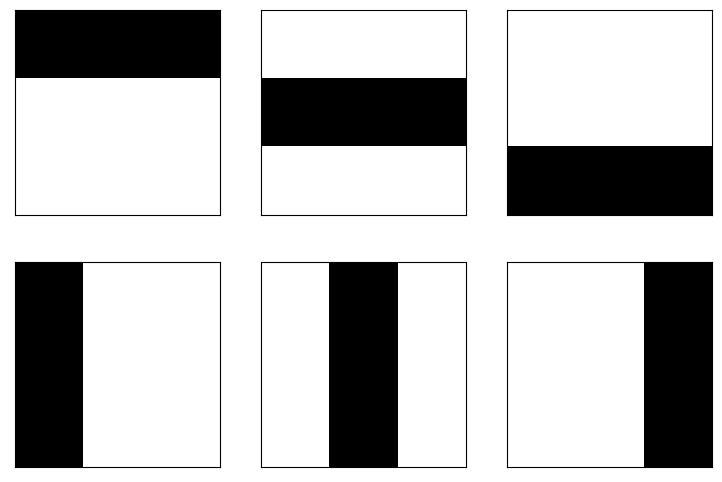

In [123]:
_ = tp_utils.visualize_topics(Theta, N_row=2, N_col=3)

## Inference

### Preprocessing the Data

If the document length is variable, `tfp` methods are not properly applicable, because as of 2022-11-15 it lacks capabilities for processing `tf.RaggedTensor`'s. Thus no (joint)-distribution can be defined which samples variable-length documents. The idea is, to pad each document to the size of the longest document base on the observed frequency of each token in the document in a catrgorical-distributed manner:

$$
    X_{\textsf{pad}}^{(j)} \overset{\textsf{iid}}{\sim} \textsf{Categorcial}\left( \frac{\textsf{count}(x_i)}{\textsf{len}(\textsf{doc}_j)}; \ i =1,\dots, V \right)
$$

This should work becaus topic models are bag-of-words models where only the (relative) frequency of token occurances matter.

In [124]:
if ragged:
    pad_token = N_vocab + 1
    single_doclengths = W_DId.nested_row_lengths()[0].numpy()
    N_words = tf.reduce_max(single_doclengths)
    N_words_mean = tf.cast(tf.reduce_mean(single_doclengths), tf.float32)

    W_DId_ragged = W_DId.to_tensor(N_vocab+1).numpy()
    W_DId = []

    def pad_single_doc(doc, length, N_words_max=N_words):
        pad_size    = N_words_max - length
        doc_padded  = doc
        doc         = doc[doc != pad_token]
        idx, freq   = np.unique(doc, return_counts=True)
        freq        = freq / np.sum(freq)
        pad         = np.random.choice(idx, size=pad_size, p=freq)
        doc_padded[doc_padded == pad_token] = pad
        return doc_padded

    for doc, length in zip(W_DId_ragged, single_doclengths):
        W_DId.append(pad_single_doc(doc, length))
    
    W_DId = tf.constant(W_DId, dtype=tf.int32)

### Defining the Joint

Orientation was provided by https://www.tensorflow.org/probability/examples/A_Tour_of_TensorFlow_Probability. Let $V$ be the size of the vocabulary, $D$ be the number of documents, $N$ be the (maximum) document size and $K$ be the number of topics. In this toy model which provides practical visualization capabilities we have $\sqrt{V} \in \mathbb N$ and $K=2*\sqrt{V} \in \mathbb N$.

The Joint Model then is:
- Topic-Token prevalences (how much a topic "likes" a word): 
$$
    \Theta \sim \textsf{Dirichlet}(\beta) \qquad \Rightarrow \qquad \Theta \in \mathbb R^{K\times V}\ \ \textsf{such that} \ \ \sum_{v=1}^V \Theta_{kv} = 1\ \forall \ k\in \{1, \dots K\}\, .
$$
- Document-Topic prevalences (how much a document "likes" a topic):
$$
    \Pi \sim \textsf{Dirichlet}(\alpha)  \qquad \Rightarrow \qquad \Pi     \in \mathbb R^{D\times K}\ \ \textsf{such that} \ \ \sum_{k=1}^K \Pi_{dk}    = 1\ \forall \ d\in \{1, \dots D\}\, .
$$
- Topic-word assignments in each document (iid for all $N$ words in a document):
$$
    C \vert \Pi \sim \textsf{Categorical}(\Pi) \qquad \Rightarrow \qquad C \in \mathbb N^{D\times N}
$$ 
- Actual words in a document: $$P(w_{di}=v \vert c_{dik}, \Theta) = \prod_k \Theta_{kv}^{c_{dik}},$$ where $c_{dik}$ is one-hot encoded. This is equivalend to $$W \vert C, \Theta \sim \textsf{Categorical}(\texttt{tf.gather(} \Theta, C \texttt{)} )\, .$$

The "$C$-step" can be "integrated out" using `tfp`'s `MixtureSameFamily`-distribution-class (see for gaussian mixture model in https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model).

In [125]:
## Priors:
alphas = tf.ones((N_docs, N_topics),  dtype=tf.float32)
betas  = tf.ones((N_topics, N_vocab), dtype=tf.float32)
        
## Joint
joint = tfd.JointDistributionNamed(
    dict(
        Pi    = tfd.Dirichlet(alphas),
        Theta = tfd.Dirichlet(betas),
        W     = lambda Pi, Theta: tfd.Sample(  
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(
                    probs=Pi
                ),
                components_distribution=tfd.Categorical(
                    probs=Theta
                )
            ),
            sample_shape=(N_words)
        )
    ),
    batch_ndims=0,
    use_vectorized_map=True
)

Testing the joint:

In [126]:
## Sampling behavior 
for key, val in joint.sample().items():
    print(f"Sample Shape {key}: {val.shape}")

## Log-probability of observed (possibly padded data) assuming the joint
p = joint.log_prob(W=W_DId, Pi=Pi, Theta=Theta).numpy()
print(f"Log-Probability of the observed data: {p}")

Sample Shape Theta: (6, 9)
Sample Shape Pi: (300, 6)
Sample Shape W: (300, 71)
Log-Probability of the observed data: -41893.22265625


Presenting documents [ 20 121 211 133 123 194  65 298   3  80]


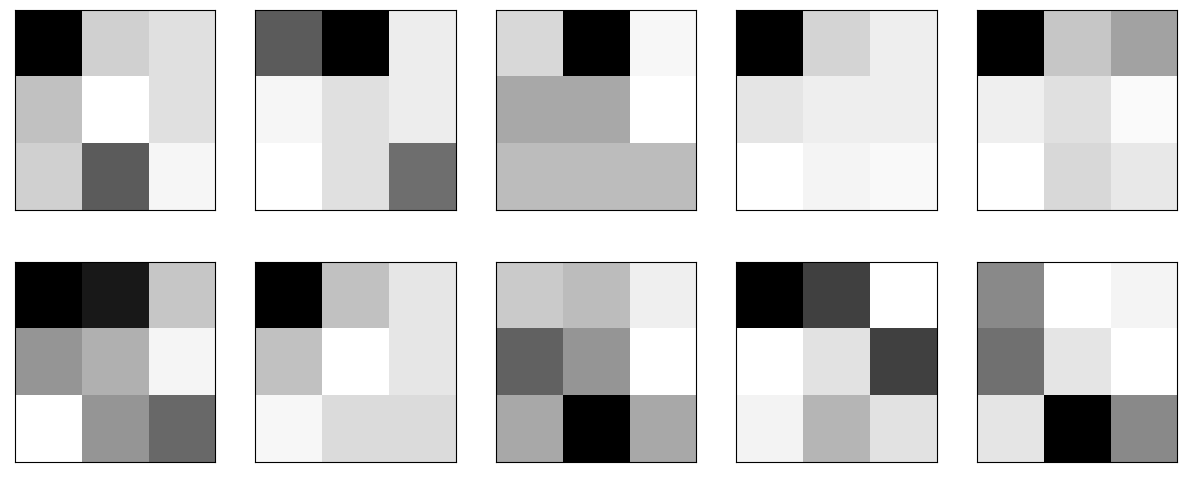

In [127]:
## Visualize documents from the prior-joint
_ = tp_utils.visualize_random_docs(joint.sample()['W'], sqrt_V=sqrt_N_vocab)

### Defining the "observed" posterior:

In [139]:
unnormalized_posterior = lambda Pi, Theta: joint.log_prob(W=W_DId, Pi=Pi, Theta=Theta)

### Defining & fitting surrogate posterior ($q$)

In [267]:
## Assuming Normal Posterior
# --------------------------

# ## Constraints
# unconstraining_bijectors = {
#     'Pi':    tfb.SoftmaxCentered(),
#     'Theta': tfb.SoftmaxCentered()
# }

# ## Event shapes
# event_shape={key: joint.event_shape_tensor()[key] for key in ('Pi', 'Theta')}

# surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
#     event_shape=event_shape, # Omitting W
#     bijector=unconstraining_bijectors
# )


## Predefined Shape
# -----------------

## Priors:
alphas = tf.Variable(tf.ones((N_docs,  N_topics),  dtype=tf.float32))
betas  = tf.Variable(tf.ones((N_topics, N_vocab), dtype=tf.float32))

## Shape
# surrogate_posterior = tfd.JointDistributionSequential([
#         tfp.experimental.util.make_trainable(
#             tfd.Dirichlet, 
#             batch_and_event_shape=alphas.shape,
#             name="Pi"),
#         tfp.experimental.util.make_trainable(
#             tfd.Dirichlet, 
#             batch_and_event_shape=betas.shape,
#             name="Theta")
#     ],
#     batch_ndims=0,
#     use_vectorized_map=True
# )

surrogate_posterior = tfd.JointDistributionNamed(
    dict(
        Pi    = tfd.Dirichlet(alphas),
        Theta = tfd.Dirichlet(betas),
    ),
    batch_ndims=0,
    use_vectorized_map=True,
)

# surrogate_posterior = tfp.experimental.util.make_trainable(surrogate_posterior)

## Constraints
# unconstraining_bijectors = tfb.JointMap([
#     tfb.SoftmaxCentered(),
#     tfb.SoftmaxCentered()
# ])

# surrogate_posterior = tfd.TransformedDistribution(
#     distribution=surrogate_posterior,
#     bijector=unconstraining_bijectors
# )

print(surrogate_posterior)

tfp.distributions.JointDistributionNamed("JointDistributionNamed", batch_shape=[], event_shape={Pi: [300, 6], Theta: [6, 9]}, dtype={Pi: float32, Theta: float32})


In [271]:
losses = tfp.vi.fit_surrogate_posterior(
    unnormalized_posterior,
    surrogate_posterior=surrogate_posterior,
    num_steps=200,
    optimizer=tf.optimizers.Adam(0.01),
    sample_size=10,
    # jit_compile=True
)

### Assessing results (Surrogate Posterior approximates true Posterior)

In [272]:
sample = surrogate_posterior.sample(100)

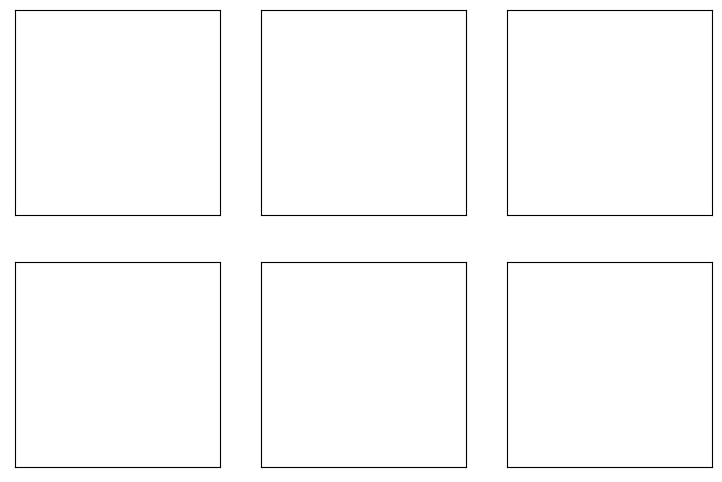

In [273]:
_ = tp_utils.visualize_topics(tf.reduce_mean(sample['Theta'], axis=0), N_row=2, N_col=3)
# _ = tp_utils.visualize_topics(tf.reduce_mean(sample[1], axis=0), N_row=2, N_col=3)